# 🌍 Phase 3 — Scenario + Policy Runner
Runs **baseline**, **drought**, **fert shock** and applies **fert subsidy** (fertilizer subsidy).

Engine: Phase 2B LP (storage + herd dynamics).


In [ ]:
# ========================================
# SETUP: IMPORT LIBRARIES AND PATHS
# ========================================
# Import the tools we need for calculations, data handling, and visualization

import json                        # For reading scenario configuration files
from dataclasses import dataclass  # For creating data structure templates
from typing import Dict            # For type hints (code documentation)
from pathlib import Path           # For handling file paths

import numpy as np                 # For numerical calculations (arrays, math)
import pandas as pd                # For working with data tables (like Excel)
from scipy.optimize import linprog # The optimization solver that finds best decisions
import matplotlib.pyplot as plt    # NEW: For creating charts and visualizations

# Try to import display tool for pretty tables
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None

# Define where our input data and outputs are stored
DATA = Path('./data_phase_3')  # Folder with CSV files for Phase 3
OUT = Path('./outputs')          # Folder where results will be saved
OUT.mkdir(exist_ok=True, parents=True)  # Create outputs folder if it doesn't exist

print('Loaded numpy, pandas, scipy.optimize.linprog, matplotlib')


Loaded numpy, pandas, scipy.optimize.linprog, matplotlib


In [ ]:
# ========================================
# LOAD AND PREVIEW INPUT DATA
# ========================================
# Read all CSV files and SCENARIO PACK configuration

# Helper function to check if required files exist
def must(path: Path) -> Path:
    """
    Checks if a file exists and raises an error if missing
    
    INPUTS: path - Path to a required file
    OUTPUTS: Returns the same path if file exists
    PURPOSE: Prevents the model from running with missing data
    """
    if not path.exists():
        raise FileNotFoundError(f'Missing required file: {path}')
    return path

# Load baseline data CSVs (same as Phase 2B)
hh_df = pd.read_csv(must(DATA/'households.csv'))         # Household characteristics
crops_df = pd.read_csv(must(DATA/'crops.csv'))           # Crop parameters
livest_df = pd.read_csv(must(DATA/'livestock.csv'))      # Livestock parameters
prices_df = pd.read_csv(must(DATA/'prices.csv'))         # Market prices (wages)
init_stocks_df = pd.read_csv(must(DATA/'initial_stocks.csv'))  # Starting crop inventory
init_herd_df = pd.read_csv(must(DATA/'initial_herd.csv'))      # Starting livestock herd

# NEW: Load SCENARIO PACK - a collection of different scenarios to test
# This replaces the single scenario file from Phase 2A/2B
# Now we can test multiple "what-if" situations at once
pack = json.load(open(must(DATA/'scenario_pack_phase3.json'),'r'))

# Display what scenarios we'll run
# Example scenarios: baseline, drought, fertilizer price shock, policy intervention
print('Scenarios:', [s['name'] for s in pack['scenarios']])

# Display what policies will be tested
# Example policy: fertilizer subsidy to help farmers
print('Policy:', pack.get('policy', {}))


Scenarios: ['baseline', 'drought', 'fert_shock']
Policy: {'name': 'fert_subsidy', 'subsidy_rate': 0.3, 'apply_to_scenarios': ['baseline', 'drought', 'fert_shock']}


In [ ]:
# ========================================
# DATA STRUCTURES (BLUEPRINTS)
# ========================================
# Same as Phase 2B - with storage and herd dynamics

@dataclass
class HouseholdClass:
    """Blueprint for a household group - same as Phase 2B"""
    name: str
    n_households: float
    adult_equiv: float
    labor_endowment: float
    land_available: float
    max_hired_labor: float

@dataclass
class CropParam:
    """Blueprint for a crop type - with storage parameters (Phase 2B)"""
    name: str
    calorie_per_kg: float
    yield_per_ha: float
    price_sale: float
    seed_cost_per_ha: float
    fert_cost_per_ha: float
    chem_cost_per_ha: float
    labor_req_per_ha: float
    storage_cost_per_kg: float    # Storage dynamics
    max_storage_kg: float          # Storage capacity
    spoilage_rate: float           # Storage losses

@dataclass
class LivestockParam:
    """Blueprint for livestock - with herd dynamics (Phase 2B)"""
    name: str
    price_sale: float
    feed_cost_per_unit: float
    vet_cost_per_unit: float
    labor_req_per_unit: float
    reproduction_rate: float       # Herd growth
    max_herd: float                # Herd capacity

@dataclass
class PriceParam:
    """Blueprint for market prices"""
    wage: float

@dataclass
class ModelParams:
    """Master container that holds ALL baseline data"""
    households: Dict[str, HouseholdClass]
    crops: Dict[str, CropParam]
    livestock: Dict[str, LivestockParam]
    prices: PriceParam
    min_kcal_per_person_per_day: float = 2000.0
    days_per_year: int = 365

# ========================================
# FUNCTION: VALIDATE AND LOAD PARAMETERS
# ========================================

def _req(x, field):
    """Validates that required fields are not missing"""
    if pd.isna(x) or str(x).strip()=='':
        raise ValueError(f'Missing value for {field}')
    return float(x)

def load_params() -> ModelParams:
    """
    Reads CSV files and creates structured parameter objects
    Same as Phase 2B
    """
    households = {str(r['name']).strip(): HouseholdClass(
        name=str(r['name']).strip(),
        n_households=_req(r['n_households'],'households.n_households'),
        adult_equiv=_req(r['adult_equiv'],'households.adult_equiv'),
        labor_endowment=_req(r['labor_endowment'],'households.labor_endowment'),
        land_available=_req(r['land_available'],'households.land_available'),
        max_hired_labor=_req(r['max_hired_labor'],'households.max_hired_labor'),
    ) for _, r in hh_df.iterrows()}

    crops = {str(r['name']).strip(): CropParam(
        name=str(r['name']).strip(),
        calorie_per_kg=_req(r['calorie_per_kg'],'crops.calorie_per_kg'),
        yield_per_ha=_req(r['yield_per_ha'],'crops.yield_per_ha'),
        price_sale=_req(r['price_sale'],'crops.price_sale'),
        seed_cost_per_ha=_req(r['seed_cost_per_ha'],'crops.seed_cost_per_ha'),
        fert_cost_per_ha=_req(r['fert_cost_per_ha'],'crops.fert_cost_per_ha'),
        chem_cost_per_ha=_req(r['chem_cost_per_ha'],'crops.chem_cost_per_ha'),
        labor_req_per_ha=_req(r['labor_req_per_ha'],'crops.labor_req_per_ha'),
        storage_cost_per_kg=_req(r['storage_cost_per_kg'],'crops.storage_cost_per_kg'),
        max_storage_kg=_req(r['max_storage_kg'],'crops.max_storage_kg'),
        spoilage_rate=_req(r['spoilage_rate'],'crops.spoilage_rate'),
    ) for _, r in crops_df.iterrows()}

    livestock = {str(r['name']).strip(): LivestockParam(
        name=str(r['name']).strip(),
        price_sale=_req(r['price_sale'],'livestock.price_sale'),
        feed_cost_per_unit=_req(r['feed_cost_per_unit'],'livestock.feed_cost_per_unit'),
        vet_cost_per_unit=_req(r['vet_cost_per_unit'],'livestock.vet_cost_per_unit'),
        labor_req_per_unit=_req(r['labor_req_per_unit'],'livestock.labor_req_per_unit'),
        reproduction_rate=_req(r['reproduction_rate'],'livestock.reproduction_rate'),
        max_herd=_req(r['max_herd'],'livestock.max_herd'),
    ) for _, r in livest_df.iterrows()}

    prices = PriceParam(wage=_req(prices_df.iloc[0]['wage'],'prices.wage'))
    return ModelParams(households=households, crops=crops, livestock=livestock, prices=prices)

# ========================================
# FUNCTION: CONVERT SCENARIO TO ARRAYS
# ========================================

def _as_T(x, T, name):
    """
    Converts scenario parameters to T-length arrays (one value per year)
    Same as Phase 2A/2B
    """
    if isinstance(x, (int,float)): 
        return [float(x)]*T
    if isinstance(x, list):
        if len(x)!=T: 
            raise ValueError(f'{name} must have length T={T}, got {len(x)}')
        return [float(v) for v in x]
    raise ValueError(f'{name} must be number or length-T list')

def scenario_arrays(s, T, r):
    """
    Converts a scenario dictionary into arrays for the optimizer
    
    INPUTS:
    - s: Scenario dictionary (from scenario_pack_phase3.json)
    - T: Number of years
    - r: Discount rate
    
    OUTPUTS: Returns 6 arrays (Y, P, W, F, POP, DISC)
    
    PURPOSE: Each scenario can have different conditions
    Examples:
    - Baseline: all multipliers = 1.0 (normal conditions)
    - Drought: yield_multiplier = [1.0, 1.0, 0.6, 1.0, 1.0] (drought in year 3)
    - Fert shock: fert_price_multiplier = 1.5 (50% price increase)
    """
    Y=_as_T(s.get('yield_multiplier',1.0),T,'yield_multiplier')
    P=_as_T(s.get('crop_price_multiplier',1.0),T,'crop_price_multiplier')
    W=_as_T(s.get('wage_multiplier',1.0),T,'wage_multiplier')
    F=_as_T(s.get('fert_price_multiplier',1.0),T,'fert_price_multiplier')
    POP=_as_T(s.get('population_multiplier',1.0),T,'population_multiplier')
    DISC=[1.0/((1.0+r)**t) for t in range(T)]
    return Y,P,W,F,POP,DISC

# ========================================
# EXECUTE: LOAD ALL PARAMETERS
# ========================================
# Load baseline parameters from CSVs
params = load_params()

# Extract global settings from scenario pack
T=int(pack['T'])                      # Number of years (same for all scenarios)
r=float(pack['discount_rate'])       # Discount rate (same for all scenarios)

print('T=',T,'r=',r)


T= 10 r= 0.1


In [ ]:
# ========================================
# OPTIMIZATION ENGINE (SAME AS PHASE 2B)
# ========================================
# These functions are identical to Phase 2B - no changes needed
# We'll use them repeatedly for different scenarios

def build_index(H, C, L, T):
    """
    Creates mapping for decision variables (same as Phase 2B)
    See Phase 2B notebook for detailed explanation
    """
    idx = {}; pos = 0
    for t in range(T):
        for h in H:
            for c in C: idx[('area', h, c, t)] = pos; pos += 1
        for h in H:
            for c in C: idx[('cons', h, c, t)] = pos; pos += 1
        for h in H:
            for c in C: idx[('sold', h, c, t)] = pos; pos += 1
        for h in H:
            for c in C: idx[('inv', h, c, t)] = pos; pos += 1
        for h in H: idx[('hired', h, None, t)] = pos; pos += 1
        for h in H: idx[('off_farm', h, None, t)] = pos; pos += 1
        for h in H:
            for l in L: idx[('herd', h, l, t)] = pos; pos += 1
        for h in H:
            for l in L: idx[('sale_live', h, l, t)] = pos; pos += 1
    return idx, pos

def init_maps(init_stocks_df, init_herd_df, H, C, L):
    """
    Loads initial conditions (same as Phase 2B)
    See Phase 2B notebook for detailed explanation
    """
    init_stock = {(str(r['household_class']).strip(), str(r['crop']).strip()): float(r['stock_kg'])
                  for _, r in init_stocks_df.iterrows()}
    init_herd = {(str(r['household_class']).strip(), str(r['livestock']).strip()): float(r['herd_units'])
                 for _, r in init_herd_df.iterrows()}
    for h in H:
        for c in C: init_stock.setdefault((h,c), 0.0)
        for l in L: init_herd.setdefault((h,l), 0.0)
    return init_stock, init_herd

def solve_phase2B(params: ModelParams, T, Ymul, Pmul, Wmul, Fmul, POPmul, DISC):
    """
    Solves multi-year optimization with storage and herd dynamics (same as Phase 2B)
    
    This is the CORE ENGINE that we run multiple times:
    - Once for each scenario (baseline, drought, fert shock)
    - Once with policy, once without policy
    
    INPUTS: Same as Phase 2B
    OUTPUTS: Optimization result, variable indices, and lists of H, C, L
    
    See Phase 2B notebook for detailed explanation of the optimization
    """
    H = list(params.households.keys())
    C = list(params.crops.keys())
    L = list(params.livestock.keys())
    idx, nvars = build_index(H, C, L, T)
    cvec = np.zeros(nvars)
    bounds = [(0, None)]*nvars
    init_stock, init_herd = init_maps(init_stocks_df, init_herd_df, H, C, L)

    # Build objective function (NPV)
    for t in range(T):
        disc = DISC[t]
        wage_t = params.prices.wage * Wmul[t]
        for h in H:
            cvec[idx[('hired', h, None, t)]] += disc*wage_t
            cvec[idx[('off_farm', h, None, t)]] += -disc*wage_t
            for cn in C:
                cp = params.crops[cn]
                cvec[idx[('sold', h, cn, t)]] += -disc*(cp.price_sale*Pmul[t])
                per_ha = cp.seed_cost_per_ha + cp.fert_cost_per_ha*Fmul[t] + cp.chem_cost_per_ha
                cvec[idx[('area', h, cn, t)]] += disc*per_ha
                cvec[idx[('inv', h, cn, t)]] += disc*cp.storage_cost_per_kg
            for l in L:
                lv = params.livestock[l]
                cvec[idx[('sale_live', h, l, t)]] += -disc*lv.price_sale
                cvec[idx[('herd', h, l, t)]] += disc*(lv.feed_cost_per_unit+lv.vet_cost_per_unit)

    A_eq=[]; b_eq=[]; A_ub=[]; b_ub=[]

    # Inventory dynamics
    for t in range(T):
        for h in H:
            for cn in C:
                cp = params.crops[cn]
                row=np.zeros(nvars)
                row[idx[('inv', h, cn, t)]] = 1.0
                row[idx[('area', h, cn, t)]] = -(cp.yield_per_ha*Ymul[t])
                row[idx[('cons', h, cn, t)]] = 1.0
                row[idx[('sold', h, cn, t)]] = 1.0
                if t==0:
                    A_eq.append(row); b_eq.append((1.0-cp.spoilage_rate)*init_stock[(h,cn)])
                else:
                    row[idx[('inv', h, cn, t-1)]] = -(1.0-cp.spoilage_rate)
                    A_eq.append(row); b_eq.append(0.0)

    # Herd dynamics
    for t in range(T):
        for h in H:
            for l in L:
                lv = params.livestock[l]
                row=np.zeros(nvars)
                row[idx[('herd', h, l, t)]] = 1.0
                row[idx[('sale_live', h, l, t)]] = 1.0
                if t==0:
                    A_eq.append(row); b_eq.append((1.0+lv.reproduction_rate)*init_herd[(h,l)])
                else:
                    row[idx[('herd', h, l, t-1)]] = -(1.0+lv.reproduction_rate)
                    A_eq.append(row); b_eq.append(0.0)

    # Land constraint
    for t in range(T):
        for h in H:
            row=np.zeros(nvars)
            for cn in C: row[idx[('area', h, cn, t)]] = 1.0
            A_ub.append(row); b_ub.append(params.households[h].land_available)

    # Labor constraint
    for t in range(T):
        for h in H:
            row=np.zeros(nvars)
            for cn in C: row[idx[('area', h, cn, t)]] = params.crops[cn].labor_req_per_ha
            for l in L: row[idx[('herd', h, l, t)]] = params.livestock[l].labor_req_per_unit
            row[idx[('off_farm', h, None, t)]] = 1.0
            row[idx[('hired', h, None, t)]] = -1.0
            A_ub.append(row); b_ub.append(params.households[h].labor_endowment)

    # Hiring limit
    for t in range(T):
        for h in H:
            row=np.zeros(nvars); row[idx[('hired', h, None, t)]] = 1.0
            A_ub.append(row); b_ub.append(params.households[h].max_hired_labor)

    # Nutrition requirement
    for t in range(T):
        for h in H:
            row=np.zeros(nvars)
            for cn in C: row[idx[('cons', h, cn, t)]] = -params.crops[cn].calorie_per_kg
            kcal_need = params.min_kcal_per_person_per_day * (params.households[h].adult_equiv*POPmul[t]) * params.days_per_year
            A_ub.append(row); b_ub.append(-kcal_need)

    # Storage capacity
    for t in range(T):
        for h in H:
            for cn in C:
                cp=params.crops[cn]
                row=np.zeros(nvars); row[idx[('inv', h, cn, t)]] = 1.0
                A_ub.append(row); b_ub.append(cp.max_storage_kg)

    # Herd capacity
    for t in range(T):
        for h in H:
            for l in L:
                lv=params.livestock[l]
                if lv.max_herd and lv.max_herd>0:
                    row=np.zeros(nvars); row[idx[('herd', h, l, t)]] = 1.0
                    A_ub.append(row); b_ub.append(lv.max_herd)

    # Solve and return
    return linprog(cvec, A_ub=np.array(A_ub), b_ub=np.array(b_ub),
                   A_eq=np.array(A_eq), b_eq=np.array(b_eq),
                   bounds=bounds, method='highs'), idx, H, C, L


In [ ]:
# ========================================
# POLICY INTERVENTION FUNCTION
# ========================================
def apply_fert_subsidy(Fmul, subsidy_rate: float):
    """
    Applies a fertilizer subsidy to reduce effective fertilizer costs
    
    INPUTS:
    - Fmul: Array of fertilizer price multipliers (one per year)
    - subsidy_rate: Subsidy percentage (0.3 = 30% subsidy)
    
    OUTPUTS: Modified fertilizer price multipliers
    
    HOW IT WORKS:
    Government pays part of the fertilizer cost, so farmers pay less
    
    EXAMPLE:
    - Baseline fertilizer cost: 100 Birr/ha
    - Subsidy rate: 0.3 (30%)
    - Farmers pay: 100 × (1 - 0.3) = 70 Birr/ha
    - Government pays: 30 Birr/ha
    
    PURPOSE: Test if subsidizing fertilizer helps farmers:
    - Reduce production costs
    - Potentially increase fertilizer use
    - Boost crop yields and income
    
    This is a POLICY INTERVENTION to support agriculture
    """
    return [f*(1.0 - subsidy_rate) for f in Fmul]

# ========================================
# RESULT SUMMARIZATION FUNCTION
# ========================================
def summarize_solution(res, idx, params, H, C, L, T, Pmul, Wmul, Fmul, DISC):
    """
    Extracts and summarizes results from an optimization solution
    
    INPUTS:
    - res: Optimization result object
    - idx: Variable index mapping
    - params: Model parameters
    - H, C, L: Lists of households, crops, livestock
    - T: Number of years
    - Pmul, Wmul, Fmul: Price/wage/fertilizer multipliers
    - DISC: Discount factors
    
    OUTPUTS:
    - yearly: DataFrame with profit by year and household
    - npv: DataFrame with NPV by household
    - total_npv: Total NPV across all households
    
    PURPOSE: Convert raw optimization results into readable tables
    Calculates profits year-by-year and NPV for each household group
    """
    x = res.x
    def v(kind, h, k, t): 
        return float(x[idx[(kind, h, k, t)]])
    
    rows=[]
    for t in range(T):
        wage_t = params.prices.wage * Wmul[t]
        for h in H:
            # Calculate revenues
            rev_crops = sum(v('sold', h, cn, t) * (params.crops[cn].price_sale * Pmul[t]) for cn in C)
            rev_livestock = sum(v('sale_live', h, l, t) * params.livestock[l].price_sale for l in L)
            rev_off = v('off_farm', h, None, t) * wage_t
            
            # Calculate costs
            cost_crop = sum(v('area', h, cn, t) * (params.crops[cn].seed_cost_per_ha + params.crops[cn].fert_cost_per_ha * Fmul[t] + params.crops[cn].chem_cost_per_ha) for cn in C)
            cost_store = sum(v('inv', h, cn, t) * params.crops[cn].storage_cost_per_kg for cn in C)
            cost_live = sum(v('herd', h, l, t) * (params.livestock[l].feed_cost_per_unit + params.livestock[l].vet_cost_per_unit) for l in L)
            cost_hired = v('hired', h, None, t) * wage_t
            
            # Calculate profit
            profit = (rev_crops + rev_livestock + rev_off) - (cost_crop + cost_store + cost_live + cost_hired)
            
            rows.append({
                'year': t+1, 
                'household_class': h,
                'profit': profit, 
                'discounted_profit': profit*DISC[t]
            })
    
    yearly = pd.DataFrame(rows)
    npv = yearly.groupby('household_class', as_index=False).agg(NPV=('discounted_profit','sum'))
    total_npv = float(npv['NPV'].sum())
    return yearly, npv, total_npv

# ========================================
# MAIN SCENARIO & POLICY RUNNER
# ========================================
# This is the CORE of Phase 3: run multiple scenarios and compare with/without policy

# Step 1: Extract policy configuration from scenario pack
policy = pack.get('policy', {})
sub_rate = float(policy.get('subsidy_rate', 0.0))  # How much subsidy (e.g., 0.3 = 30%)
apply_to = set(policy.get('apply_to_scenarios', []))  # Which scenarios get the policy

# Step 2: Initialize result containers
npv_long = []      # Will store NPV for each household × scenario × variant
totals = []        # Will store total NPV for each scenario × variant
yearly_all = []    # Will store yearly profits for all runs

# Step 3: Loop through each scenario
# For each scenario, we run the model TWICE:
#   1. Without policy (baseline scenario impact)
#   2. With policy (if applicable) to see policy effect
for sc in pack['scenarios']:
    name = sc['name']
    print(f"\n--- Running scenario: {name} ---")
    
    # Convert scenario to arrays
    Y,P,W,F,POP,DISC = scenario_arrays(sc, T, r)

    # ========================================
    # RUN 1: NO POLICY (baseline scenario)
    # ========================================
    # Solve optimization with scenario conditions, no policy intervention
    res0, idx0, H, C, L = solve_phase2B(params, T, Y, P, W, F, POP, DISC)
    
    if not res0.success:
        raise RuntimeError(f"Scenario '{name}' failed: {res0.message}")
    
    # Extract and save results
    yearly0, npv0, total0 = summarize_solution(res0, idx0, params, H, C, L, T, P, W, F, DISC)
    
    # Store total NPV for this scenario without policy
    totals.append({'scenario': name, 'variant': 'no_policy', 'total_NPV': total0})
    
    # Store NPV by household
    tmp = npv0.copy()
    tmp['scenario']=name
    tmp['variant']='no_policy'
    npv_long.append(tmp)
    
    # Store yearly results
    yearly0['scenario']=name
    yearly0['variant']='no_policy'
    yearly_all.append(yearly0)

    # ========================================
    # RUN 2: WITH POLICY (if applicable)
    # ========================================
    # Check if this scenario should have the policy applied
    if policy and name in apply_to:
        print(f"  Applying policy: {policy.get('name', 'policy')}")
        
        # Apply fertilizer subsidy - reduces fertilizer costs
        Fp = apply_fert_subsidy(F, sub_rate)
        
        # Solve optimization again with subsidized fertilizer prices
        resp, idxp, H, C, L = solve_phase2B(params, T, Y, P, W, Fp, POP, DISC)
        
        if not resp.success:
            raise RuntimeError(f"Scenario '{name}' + policy failed: {resp.message}")
        
        # Extract and save results
        yearlyP, npvP, totalP = summarize_solution(resp, idxp, params, H, C, L, T, P, W, Fp, DISC)
        
        # Store total NPV for this scenario WITH policy
        totals.append({'scenario': name, 'variant': f"policy_{policy.get('name','policy')}", 'total_NPV': totalP})
        
        # Store NPV by household
        tmp = npvP.copy()
        tmp['scenario']=name
        tmp['variant']=f"policy_{policy.get('name','policy')}"
        npv_long.append(tmp)
        
        # Store yearly results
        yearlyP['scenario']=name
        yearlyP['variant']=f"policy_{policy.get('name','policy')}"
        yearly_all.append(yearlyP)

# Step 4: Combine all results into master tables
npv_long_df = pd.concat(npv_long, ignore_index=True)[['scenario','variant','household_class','NPV']]
totals_df = pd.DataFrame(totals)
yearly_all_df = pd.concat(yearly_all, ignore_index=True)

# ========================================
# CALCULATE POLICY IMPACTS
# ========================================
# For scenarios that had policy applied, calculate the difference:
# Impact = NPV_with_policy - NPV_without_policy

impacts=[]
for scn in npv_long_df['scenario'].unique():
    # Get baseline (no policy) results for this scenario
    base = npv_long_df[(npv_long_df['scenario']==scn) & (npv_long_df['variant']=='no_policy')].set_index('household_class')
    
    # Get policy results for this scenario
    pol  = npv_long_df[(npv_long_df['scenario']==scn) & (npv_long_df['variant'].str.startswith('policy_'))].set_index('household_class')
    
    # Skip if no policy was applied to this scenario
    if len(pol)==0: 
        continue
    
    # Join baseline and policy results
    join = base.join(pol, lsuffix='_base', rsuffix='_pol', how='inner')
    
    # Calculate impact for each household
    for h in join.index:
        b = float(join.loc[h,'NPV_base'])  # NPV without policy
        p = float(join.loc[h,'NPV_pol'])   # NPV with policy
        
        impacts.append({
            'scenario': scn, 
            'household_class': h, 
            'NPV_no_policy': b, 
            'NPV_policy': p,
            'delta_NPV': p-b,  # Absolute change
            'pct_change_%': 100.0*(p-b)/(abs(b)+1e-9)  # Percentage change
        })

impacts_df = pd.DataFrame(impacts)

# ========================================
# DISPLAY RESULTS
# ========================================
# Show the three main result tables:
# 1. NPV by household, scenario, and variant
# 2. Total NPV by scenario and variant
# 3. Policy impacts (how much did the policy help?)

if display_dataframe_to_user:
    display_dataframe_to_user('Phase 3 — NPV by household', npv_long_df)
    display_dataframe_to_user('Phase 3 — totals', totals_df)
    display_dataframe_to_user('Phase 3 — policy impacts', impacts_df)
else:
    display(npv_long_df.head())
    display(totals_df)
    display(impacts_df.head())

# ========================================
# SAVE RESULTS TO CSV
# ========================================
npv_long_df.to_csv(OUT/'phase3_scenario_household_npv.csv', index=False)
totals_df.to_csv(OUT/'phase3_scenario_totals.csv', index=False)
impacts_df.to_csv(OUT/'phase3_policy_impacts.csv', index=False)
yearly_all_df.to_csv(OUT/'phase3_yearly_all.csv', index=False)

print('\n✅ Saved outputs in ./outputs/')
print(f"   - NPV by household: phase3_scenario_household_npv.csv")
print(f"   - Scenario totals: phase3_scenario_totals.csv")
print(f"   - Policy impacts: phase3_policy_impacts.csv")
print(f"   - Yearly details: phase3_yearly_all.csv")


,scenario,variant,household_class,NPV
0,baseline,no_policy,HFR,183477.081005
1,baseline,no_policy,HMR,217760.539557
2,baseline,no_policy,MFIR,271945.943736
3,baseline,no_policy,MFR,238525.950476
4,baseline,no_policy,MMIR,315805.249280


,scenario,variant,total_NPV
0,baseline,no_policy,1.499461e+06
1,baseline,policy_fert_subsidy,1.526632e+06
2,drought,no_policy,1.429481e+06
3,drought,policy_fert_subsidy,1.456652e+06
4,fert_shock,no_policy,1.454175e+06
5,fert_shock,policy_fert_subsidy,1.494932e+06


,scenario,household_class,NPV_no_policy,NPV_policy,delta_NPV,pct_change_%
0,baseline,HFR,183477.081005,186721.412437,3244.331432,1.768249
1,baseline,HMR,217760.539557,221815.953847,4055.414290,1.862327
2,baseline,MFIR,271945.943736,276812.440884,4866.497148,1.789509
3,baseline,MFR,238525.950476,242581.364766,4055.414290,1.700198
4,baseline,MMIR,315805.249280,321888.370714,6083.121435,1.926226


Saved outputs in ./outputs/


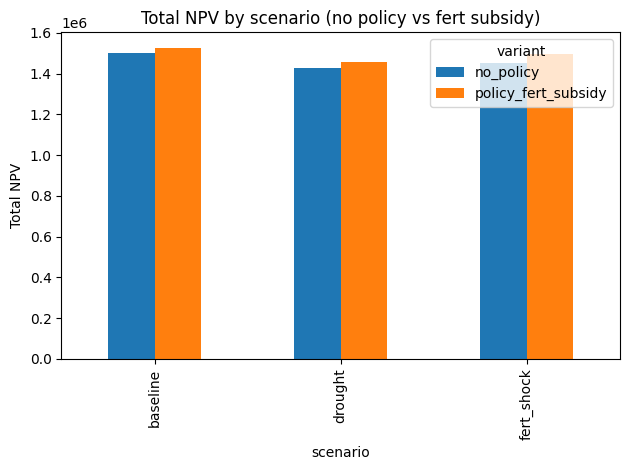

In [ ]:
# ========================================
# VISUALIZATION: COMPARE SCENARIOS & POLICY
# ========================================
# Create a bar chart showing total NPV for each scenario
# Compares no_policy vs with_policy side-by-side

if len(totals_df)>0:
    # Reshape data for plotting
    # Rows = scenarios, Columns = variants (no_policy, policy)
    piv = totals_df.pivot(index='scenario', columns='variant', values='total_NPV')
    
    # Ensure scenarios appear in the order defined in scenario pack
    piv = piv.reindex(index=[s['name'] for s in pack['scenarios']])
    
    # Create bar chart
    ax = piv.plot(kind='bar', figsize=(10, 6))
    ax.set_ylabel('Total NPV (Birr)')
    ax.set_xlabel('Scenario')
    ax.set_title('Total NPV Comparison: Scenarios & Policy Impact')
    ax.legend(title='Variant')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # INTERPRETATION GUIDE:
    # - Each group of bars = one scenario (baseline, drought, fert_shock, etc.)
    # - Blue bar = NPV without policy
    # - Orange bar = NPV with policy (if applied)
    # - Taller orange bar = policy helped increase NPV
    # - Compare across scenarios to see:
    #   * How bad is drought impact?
    #   * Does policy help more in drought vs normal years?
    #   * Which household groups benefit most?
